In [44]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_pickle("/content/drive/Shareddrives/TNT/정규세션/2021년 2학기/산업인공지능/TASK2-wafer map /LSWMD.pkl")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [6]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


### EDA 

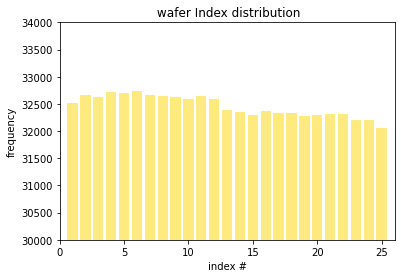

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [8]:
df = df.drop(['waferIndex'], axis = 1)

In [9]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
161372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",515.0,lot10415,[],[],"(25, 27)"
742754,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",895.0,lot44754,[[Test]],[[none]],"(33, 35)"
62438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot4862,[],[],"(30, 34)"
99481,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2422.0,lot6914,[],[],"(72, 43)"
617473,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot38756,[],[],"(33, 33)"


In [10]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [11]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [12]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


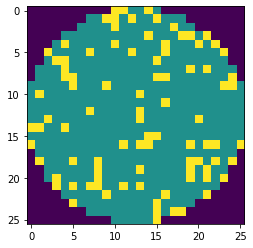

Faulty case : ['none'] 


In [13]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [14]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [15]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [16]:
faulty_case_dict =dict()

In [17]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [18]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [19]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

## Convolutional Autoencoder for augmentation.
불균형 문제를 해결할 필요성을 확인함. <br>
이미지 데이터인 wafermap을 convolution AE를 활용해 해결시도

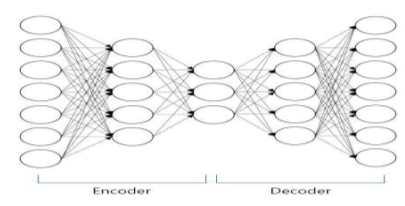

In [20]:
# parameter
epoch=15
batch_size=1024

In [21]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Check summary

In [22]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [23]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 17s - loss: 0.1558
Epoch 2/15
15/15 - 0s - loss: 0.0974
Epoch 3/15
15/15 - 0s - loss: 0.0844
Epoch 4/15
15/15 - 0s - loss: 0.0738
Epoch 5/15
15/15 - 0s - loss: 0.0646
Epoch 6/15
15/15 - 0s - loss: 0.0577
Epoch 7/15
15/15 - 0s - loss: 0.0517
Epoch 8/15
15/15 - 0s - loss: 0.0468
Epoch 9/15
15/15 - 0s - loss: 0.0420
Epoch 10/15
15/15 - 0s - loss: 0.0372
Epoch 11/15
15/15 - 0s - loss: 0.0328
Epoch 12/15
15/15 - 0s - loss: 0.0290
Epoch 13/15
15/15 - 0s - loss: 0.0259
Epoch 14/15
15/15 - 0s - loss: 0.0233
Epoch 15/15
15/15 - 0s - loss: 0.0212


In [24]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [25]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [26]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [27]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

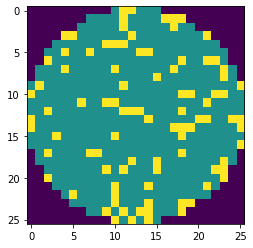

In [28]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

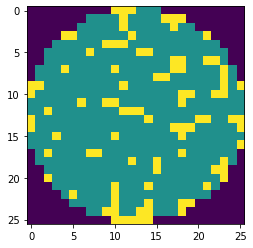

In [29]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

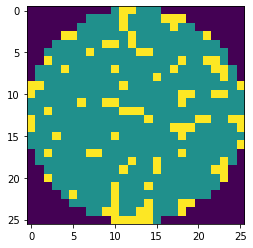

In [30]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

## Data augmentation


In [31]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [32]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [33]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [34]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [35]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [36]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [37]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [38]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [39]:
from tensorflow.keras.utils import to_categorical
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
new_y = to_categorical(new_y)

In [40]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=42)

In [41]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


### 모델 생성

In [42]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

### Cross validate model

In [45]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 3s - loss: 2.2852 - accuracy: 0.2343
Epoch 2/10
9/9 - 1s - loss: 1.0510 - accuracy: 0.6105
Epoch 3/10
9/9 - 1s - loss: 0.5976 - accuracy: 0.7974
Epoch 4/10
9/9 - 1s - loss: 0.3421 - accuracy: 0.8905
Epoch 5/10
9/9 - 1s - loss: 0.2021 - accuracy: 0.9400
Epoch 6/10
9/9 - 1s - loss: 0.1012 - accuracy: 0.9739
Epoch 7/10
9/9 - 1s - loss: 0.0647 - accuracy: 0.9824
Epoch 8/10
9/9 - 1s - loss: 0.0456 - accuracy: 0.9894
Epoch 9/10
9/9 - 1s - loss: 0.0371 - accuracy: 0.9903
Epoch 10/10
9/9 - 1s - loss: 0.0242 - accuracy: 0.9948
5/5 - 0s - loss: 0.0564 - accuracy: 0.9839
Epoch 1/10
9/9 - 1s - loss: 2.0436 - accuracy: 0.2915
Epoch 2/10
9/9 - 1s - loss: 1.0136 - accuracy: 0.6282
Epoch 3/10
9/9 - 1s - loss: 0.8086 - accuracy: 0.7245
Epoch 4/10
9/9 - 1s - loss: 0.5276 - accuracy: 0.8272
Epoch 5/10
9/9 - 1s - loss: 0.2860 - accuracy: 0.9104
Epoch 6/10
9/9 - 1s - loss: 0.1631 - accuracy: 0.9504
Epoch 7/10
9/9 - 1s - loss: 0.0869 - accuracy: 0.9766
Epoch 8/10
9/9 - 1s - loss: 0.0437 - a

Our model seems quite a good model.

In [47]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=50,
         batch_size=batch_size,
         )

Epoch 1/50
13/13 - 2s - loss: 2.1014 - accuracy: 0.3298 - val_loss: 1.2183 - val_accuracy: 0.6047
Epoch 2/50
13/13 - 1s - loss: 0.8919 - accuracy: 0.6777 - val_loss: 0.7060 - val_accuracy: 0.7222
Epoch 3/50
13/13 - 1s - loss: 0.6437 - accuracy: 0.7876 - val_loss: 0.5102 - val_accuracy: 0.8373
Epoch 4/50
13/13 - 1s - loss: 0.3477 - accuracy: 0.8915 - val_loss: 0.2814 - val_accuracy: 0.9045
Epoch 5/50
13/13 - 1s - loss: 0.1936 - accuracy: 0.9377 - val_loss: 0.1564 - val_accuracy: 0.9505
Epoch 6/50
13/13 - 1s - loss: 0.1094 - accuracy: 0.9681 - val_loss: 0.0968 - val_accuracy: 0.9702
Epoch 7/50
13/13 - 1s - loss: 0.0604 - accuracy: 0.9847 - val_loss: 0.0655 - val_accuracy: 0.9834
Epoch 8/50
13/13 - 1s - loss: 0.0372 - accuracy: 0.9915 - val_loss: 0.0445 - val_accuracy: 0.9875
Epoch 9/50
13/13 - 1s - loss: 0.0233 - accuracy: 0.9955 - val_loss: 0.0412 - val_accuracy: 0.9894
Epoch 10/50
13/13 - 1s - loss: 0.0168 - accuracy: 0.9968 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 11/50
13/13 -

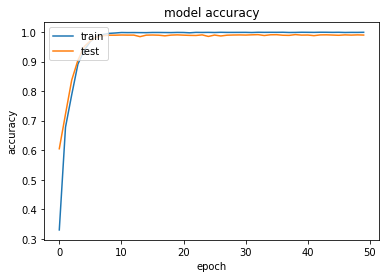

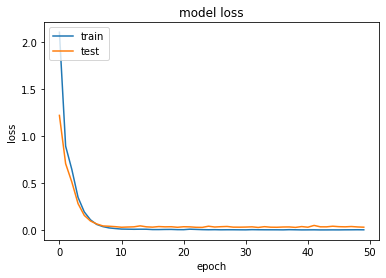

In [50]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()